## Hovmöller plot of ssh along the coast (Run 08 - faster pulse)

1. Find lon index of first cell that is not land from east to west for each lat.
2. Subtract one to the lon index found to make sure it is water.
3. Find lat index of first cell that is not land from north to south for each lon.
4. Subtract one to the lat index found to make sure it is water.
5. Integrate all points so that I get good coverage of the coastline.
6. Save index in a lon indices array.
7. Plot hovmoller diagram using all lats and lon index array.

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import pandas as pd
from scipy import signal
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
def create_nc_file(dist_array, time_array, curtain_data, filename,
                   title, description, units='m', name='SSH'):
    
    """ This function creates a netCDF4 file for
    the curtain plot data given the filename. 
    
    :arg dist_array: np 2D array, distance from bay array from meshgrid
    :arg time_array: np 2D array, time array from meshgrid
    :arg curtain_data: np 2D array of data to plot in curtain hovmöller. Size is (len(dist_array),len(time_array))
    :arg filename: str, Directory and name of netcdf file
    :arg title: str, title of plot
    :arg description: str, Details about the data
    """
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', curtain_data.shape[1])
    file_t = dataset.createDimension('t', curtain_data.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('x'))
    file_T = dataset.createVariable('T', 'f8', ('t'))
    curt_data = dataset.createVariable('curtain_data', 'f8', ('t','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'ICACC-UNAM'
    dataset.source = '/notebooks/MITgcm/domain5/ssh_hovmoller_at_coast_all_points-2xTau.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Distance along the coast from SVB'
    file_X.units = 'km'
    file_T.standard_name = 'time'
    file_T.units = 's'
    curt_data.standard_name = name
    curt_data.units = units
    
    file_X[:] = dist_array[:]
    file_T[:] = time_array[:]
    curt_data[:] = curtain_data[:]

    dataset.close()

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/08_SVB_fasterPulse/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/08_noSVB_fasterPulse/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [4]:
nx = 512
ny = 612
nz = 100
nt = 720

In [5]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
times = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

### 1. Find lon index of first water point from east to west for each lat

Find cells along lat where hFacC is 1.

In [6]:
lon_inds_off = np.argmax(np.squeeze(hFacCSVB[0,:,::-1].data), axis=1)

ini_lat_ind = 220 # Lat just above and outside SVB

lon_inds = np.ones_like(lon_inds_off[ini_lat_ind:])*nx - lon_inds_off[ini_lat_ind:]
lat_inds = np.ones_like(lon_inds)*ini_lat_ind + np.arange(len(lon_inds))

There are some points missing along the coast that have the same lat. Now find along lon:

In [7]:
lat_inds_off = np.argmax(np.squeeze(hFacCSVB[0,::-1,:].data), axis=0)
ini_lon_ind = 50 # Lon of land at N boundary

lat_inds_2 = np.ones_like(lat_inds_off[ini_lon_ind:])*ny - lat_inds_off[ini_lon_ind:]
lon_inds_2 = np.ones_like(lat_inds)*ini_lon_ind + np.arange(len(lat_inds))

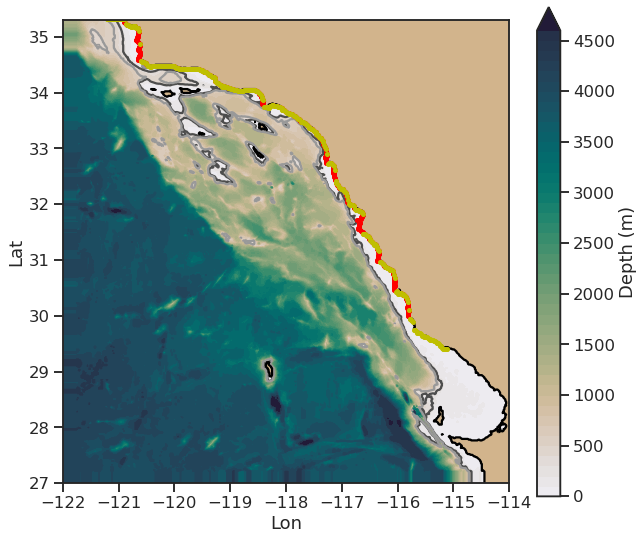

In [8]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(depthSVB, mask=mask_depSVB),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(lon,lat,depth, colors=['0.3','0.6'], 
                levels=[250,500])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='k')

# cells along coast(ish)
for ii,jj in zip(lon_inds,lat_inds):
    ax.plot(LON[0,ii-1],LAT[jj,0],'o', 
            markersize=4, color='r')
    #print('Depth at cell is %1.2f m' % (depth[jj,ii-1]))

# cells along coast(ish)
for ii,jj in zip(lon_inds_2,lat_inds_2):
    ax.plot(LON[0,ii],LAT[jj-1,0],'o', 
            markersize=4, color='y')
    #print('Depth at cell is %1.2f m' % (depth[jj,ii-1]))

cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

In [9]:
df = pd.read_csv('coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )

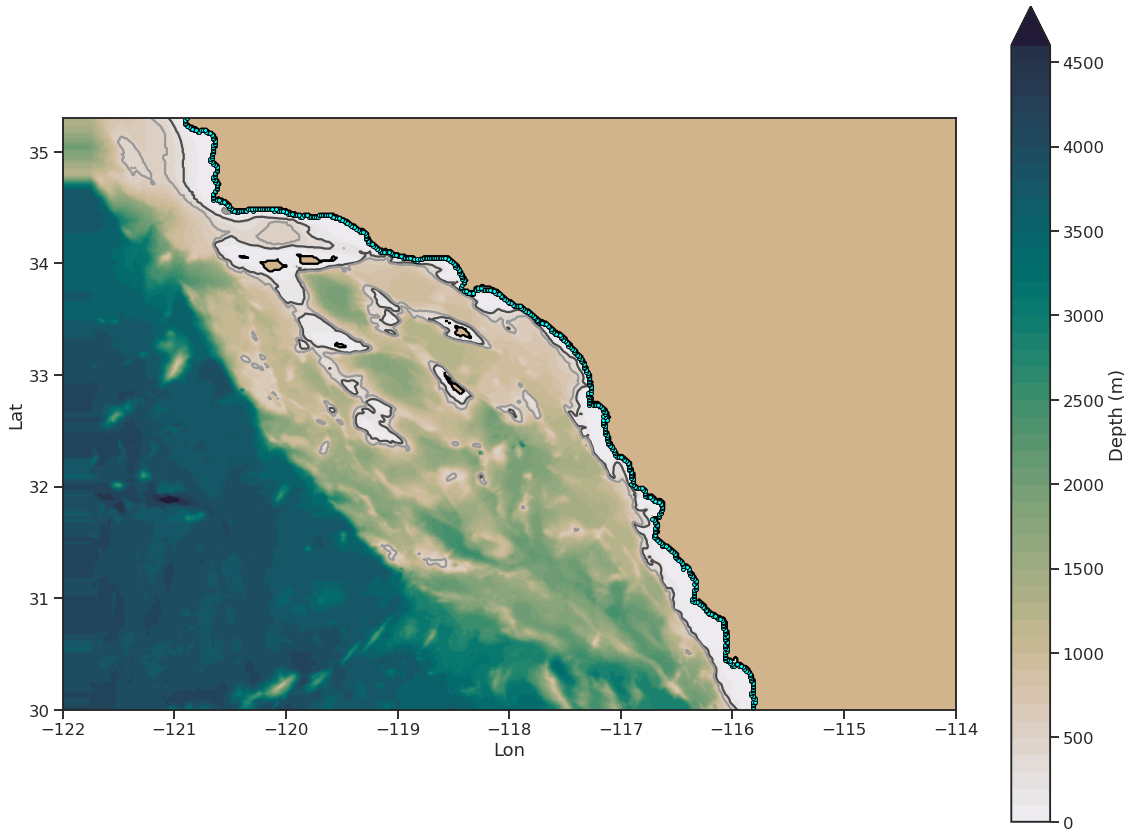

In [10]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(20,15))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(depthSVB, mask=mask_depSVB),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(lon,lat,depth, colors=['0.3','0.6'], 
                levels=[250,500])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='k')

# cells along coast(ish)
for ii,jj in zip(df.lon_ii[:], df.lat_jj[:]):
    #print(ii,jj)
    ax.plot(LON[0,int(ii)-1],LAT[int(jj)-1,0],'o', 
            markersize=4, color='cyan', markeredgecolor='k')
    #print('%d %d Depth at cell is %1.2f m' % (int(ii),int(jj),depth[jj-1,ii-1]))

cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(30,35.3)
ax.set_aspect(1)

### Hovmöller 

In [11]:
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [12]:
# Distance along the coast (haversine)
def distance(lat1,lon1,lat2,lon2):
    '''Distance using Haversine formula'''
    r = 6371 #radius of Earth (KM)
    p = np.pi/180  #Pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    d = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin In km
    return d

In [13]:
dist_array = np.zeros(len(lon_ii))

for kk in range(1,len(lon_ii)):
    lat1 = lat[lat_jj[kk-1]]
    lon1 = lon[lon_ii[kk-1]]
    lat2 = lat[lat_jj[kk]]
    lon2 = lon[lon_ii[kk]]
    dist_array[kk]=  distance(lat1, lon1, lat2, lon2)

In [14]:
dist_cummul = np.cumsum(dist_array)

In [15]:
times = np.arange(720)*600

In [ ]:
# This cell takes a while (about 10 min), that is why I save the data in next cell
ssh = np.zeros((nt,len(lon_ii)))

for ii,jj,kk in zip(lon_ii, lat_jj, range(len(lon_ii))):
    ssh[:,kk] = ds['ETAN'][:,jj,ii]

In [ ]:
filename = 'curtain_SSH_SVB_fasterPulse.nc'
description = 'SSH data at points along the coast to build curtain hovmöller plot for faster pulse'
title = 'SSH curtain plot data faster pulse SVB'

create_nc_file(dist_cummul, times, ssh, filename,
               title, description, units='m', name='SSH')

In [ ]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600*24),dist_cummul,np.transpose(ssh*100),
                   vmin=-1.6, vmax=1.6, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')
# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(4,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('days')
ax.set_title('SVB run')

In [ ]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600),dist_cummul,np.transpose(ssh*100),
                   vmin=-1.6, vmax=1.6, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')
# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(20,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.set_xlim(0,24)
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Hours')
ax.set_title('SVB run')

## No SVB run

In [20]:
# This cell takes a while (about 10 min)
ssh_NOB = np.zeros((nt,len(lon_ii)))

for ii,jj,kk in zip(lon_ii, lat_jj, range(len(lon_ii))):
    ssh_NOB[:,kk] = ds2['ETAN'][:,jj,ii]

In [21]:
filename2 = 'curtain_SSH_NoSVB_fasterPulse.nc'
description2 = 'SSH data at points along the coast to build curtain hovmöller plot for no SVB run faster pulse'
title2 = 'SSH curtain plot data faster pulse NO SVB'

create_nc_file(dist_cummul, times, ssh_NOB, filename2,
               title2, description2, units='m', name='SSH')

Text(0.5, 1.0, 'No SVB run')

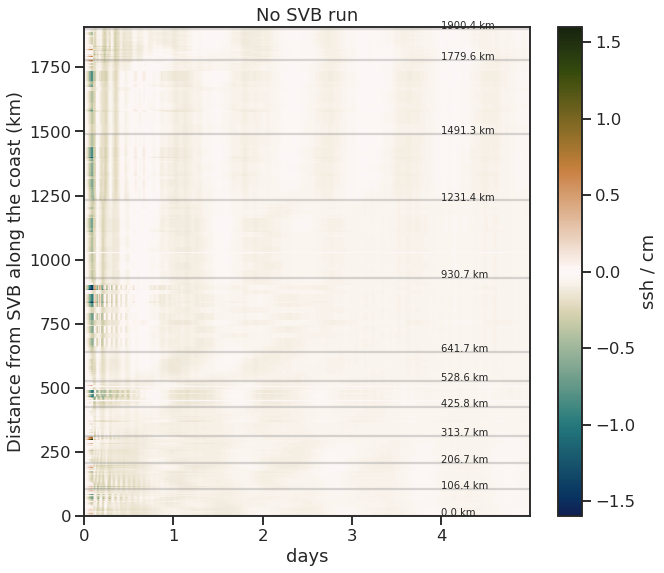

In [22]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600*24),dist_cummul,np.transpose(ssh_NOB*100),
                   vmin=-1.6, vmax=1.6, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')
# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(4,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('days')
ax.set_title('No SVB run')

Text(0.5, 1.0, 'No SVB run')

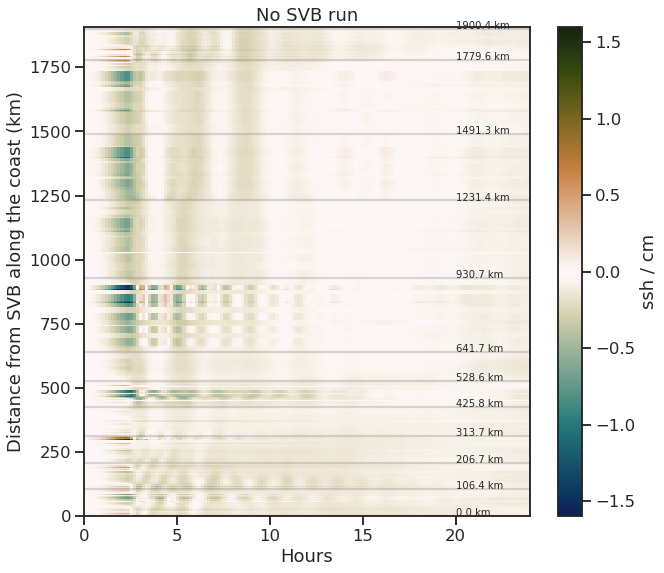

In [23]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600),dist_cummul,np.transpose(ssh_NOB*100),
                   vmin=-1.6, vmax=1.6, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')

# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(20,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.set_xlim(0,24)
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Hours')
ax.set_title('No SVB run')

## Bay minus no Bay 

Text(0.5, 1.0, 'SVB-No SVB')

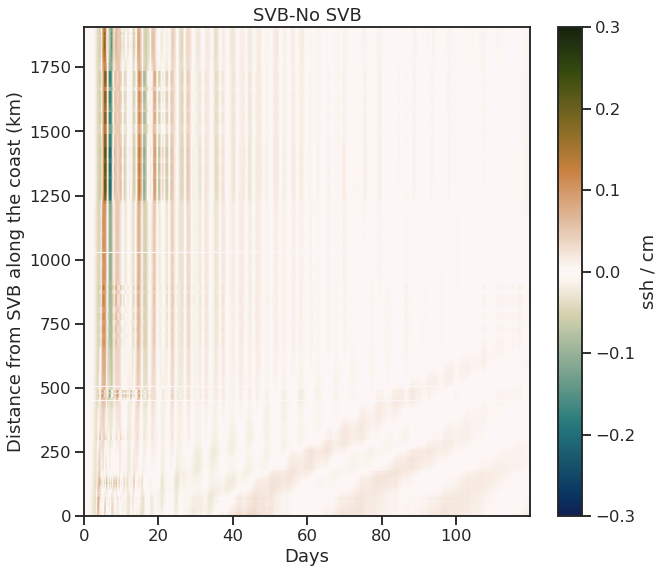

In [39]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600),dist_cummul,np.transpose((ssh-ssh_NOB)*100),
                   vmin=-0.3, vmax=0.3, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')

ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Days')
ax.set_title('SVB-No SVB')

Text(0.5, 1.0, 'SVB-No SVB')

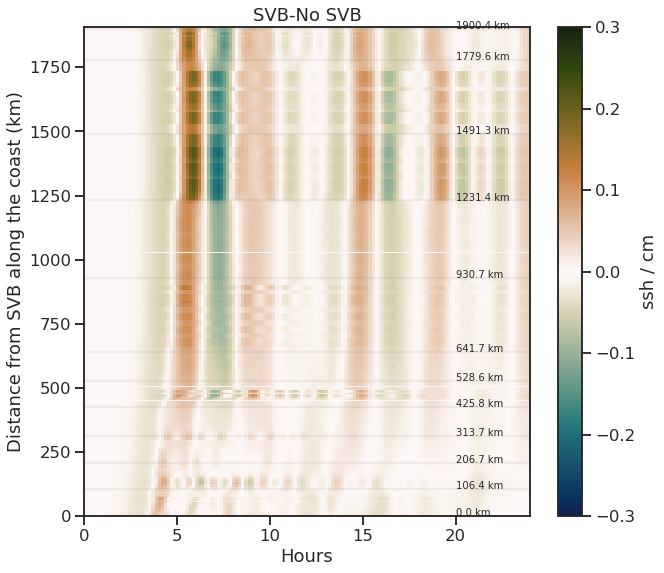

In [40]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(times/(3600),dist_cummul,np.transpose((ssh-ssh_NOB)*100),
                   vmin=-0.3, vmax=0.3, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')


# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.1)
        ax.text(20,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

#ax.plot(5,0,'ko')
#ax.plot(6.6,700, 'ko')
ax.set_xlim(0,24)
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Hours')
ax.set_title('SVB-No SVB')

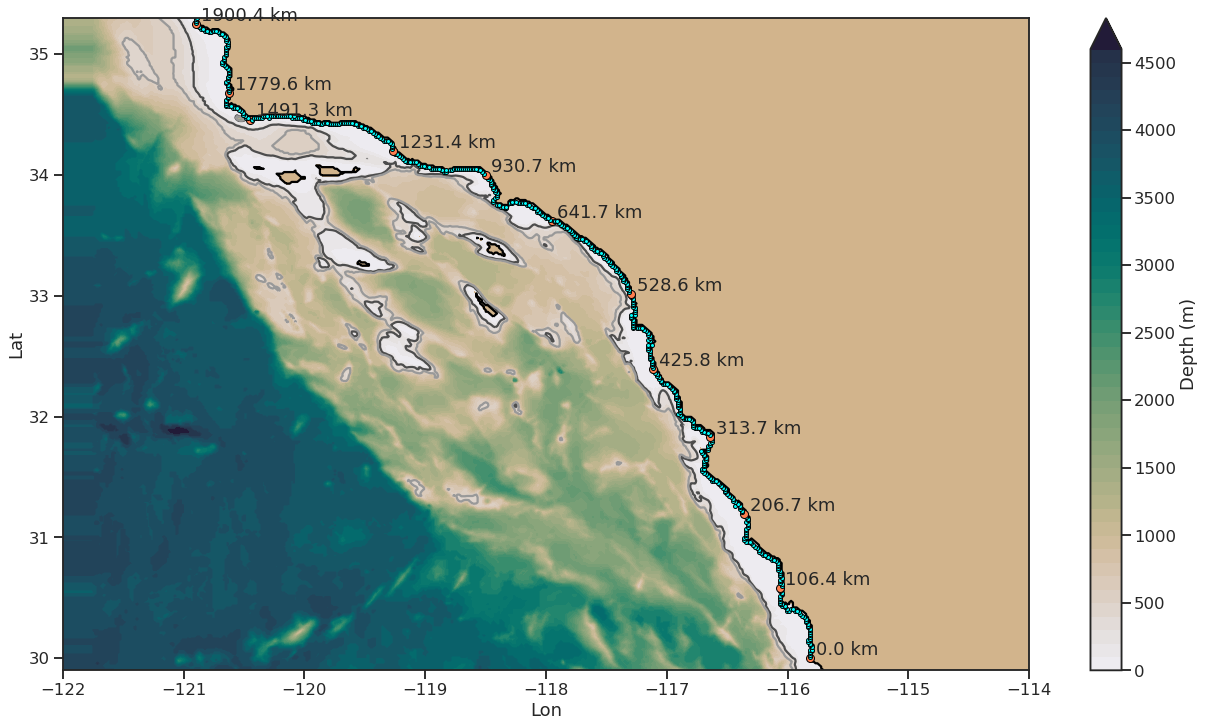

In [41]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(22,12))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(depthSVB, mask=mask_depSVB),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(lon,lat,depth, colors=['0.3','0.6'], 
                levels=[250,500])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='k')

# cells along coast(ish)
for ii,jj,kk in zip(lon_ii[:], lat_jj[:],range(len(lon_ii))):
    #print(ii,jj)
    ax.plot(LON[0,int(ii)],LAT[int(jj),0],'o', 
            markersize=4, color='cyan', markeredgecolor='k')
    if kk%50 == 0:
        ax.plot(LON[0,int(ii)],LAT[int(jj),0],'o', 
                markersize=8, color='coral', markeredgecolor='k')
        ax.text(LON[0,int(ii)+3],LAT[int(jj)+2,0],'%1.1f km' %dist_cummul[kk])

cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(29.9,35.3)
ax.set_aspect(1)

Text(0.5, 1.0, 'SVB-No SVB')

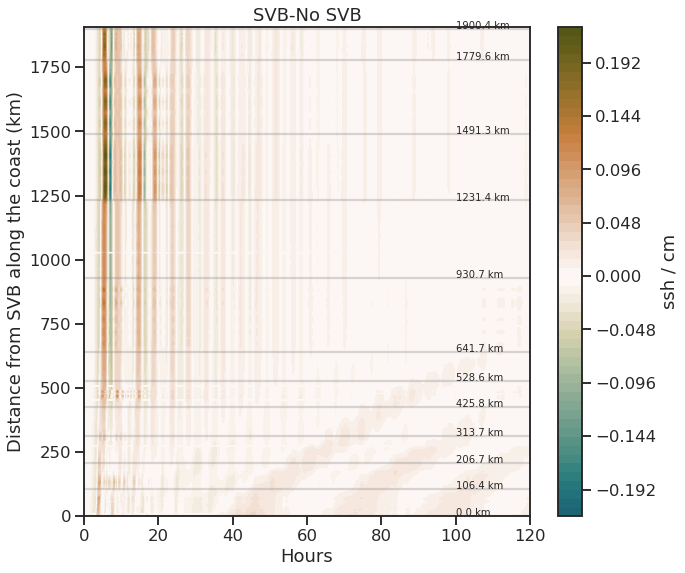

In [42]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.contourf(times/(3600),dist_cummul,np.transpose((ssh-ssh_NOB)*100), 61,
                vmin=-0.3, vmax=0.3, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')


# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(20*5,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.set_xlim(0,24*5)
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Hours')
ax.set_title('SVB-No SVB')

Text(0.5, 1.0, 'SVB-No SVB')

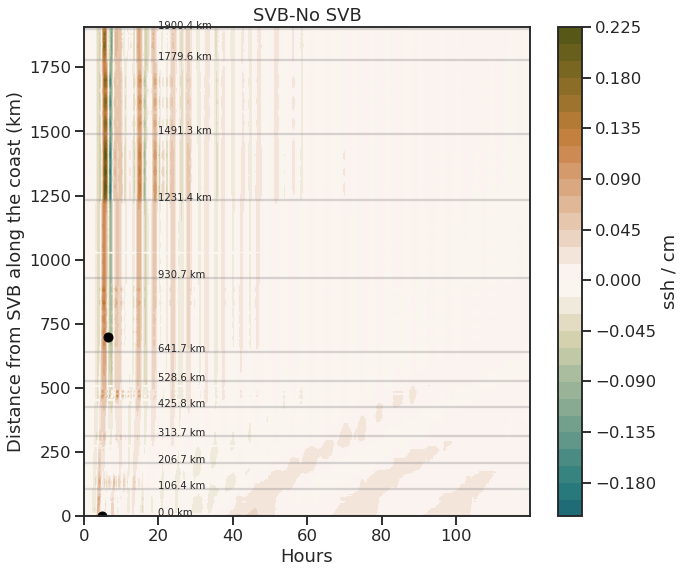

In [43]:
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.contourf(times/(3600),dist_cummul,np.transpose((ssh-ssh_NOB)*100), 41,
                vmin=-0.3, vmax=0.3, cmap=cmo.cm.tarn_r)
cb = plt.colorbar(pc,label='ssh / cm')


# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.axhline(dist_cummul[kk],color='0.5',alpha=0.3)
        ax.text(20,dist_cummul[kk],'%1.1f km' %dist_cummul[kk], fontsize=10)

ax.plot(5,0,'ko')
ax.plot(6.6,700, 'ko')
ax.set_xlim(0,)
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('Hours')
ax.set_title('SVB-No SVB')

### Timeseries

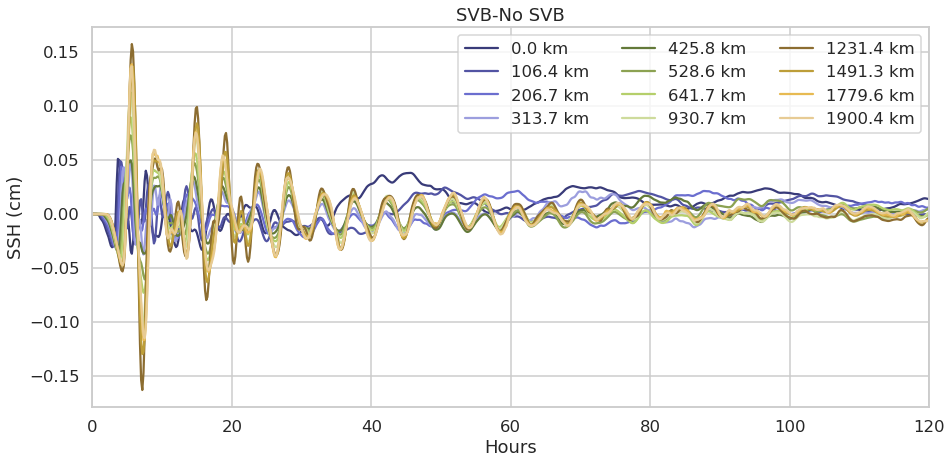

In [44]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('tab20b',n_colors=20)
fig, ax = plt.subplots(1,1,figsize=(15,7))

# cells along coast(ish)
for kk in range(len(lon_ii)):
    if kk%50 == 0:
        ax.plot(times[:]/3600,(ssh[:,kk]-ssh_NOB[:,kk])*100, label='%1.1f km' %dist_cummul[kk])

ax.set_ylabel('SSH (cm)')
ax.set_xlabel('Hours')
ax.set_title('SVB-No SVB')
ax.set_xlim(0,120)
ax.legend(ncol=3)

In [45]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

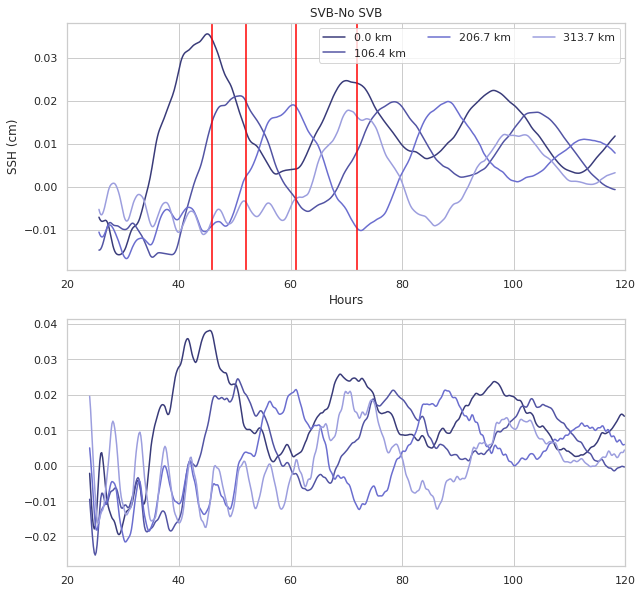

In [46]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('tab20b',n_colors=20)
fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,10))

# cells along coast(ish)
for kk in [0,50,100,150]:
    avg = moving_average((ssh[144:,kk]-ssh_NOB[144:,kk])*100, 21)
    ax.plot(times[144+10:-10]/3600, avg, label='%1.1f km' %dist_cummul[kk])
    ax2.plot(times[144:]/3600,(ssh[144:,kk]-ssh_NOB[144:,kk])*100, label='%1.1f km' %dist_cummul[kk])

ax.axvline(46, color='r')
ax.axvline(52, color='r')
ax.axvline(61, color='r')
ax.axvline(72, color='r')

ax.set_ylabel('SSH (cm)')
ax.set_xlabel('Hours')
ax.set_title('SVB-No SVB')
ax.set_xlim(20,120)
ax2.set_xlim(20,120)

ax.legend(ncol=3)

Text(0.5, 1.0, 'SSH spectra stations along the coast')

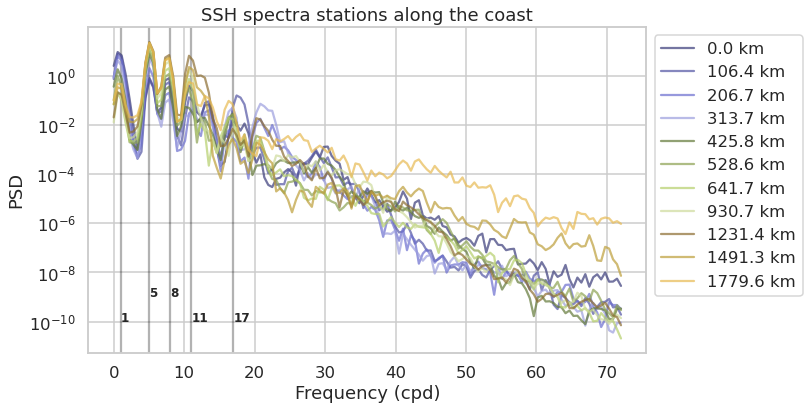

In [47]:
sns.set_style('whitegrid')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax) = plt.subplots(1,1,figsize=(10,6))

# Useful freq to period indicators
ax.axvline(1, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(5, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(8, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(11, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(17, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period

# ax.axvline(1e4/(8*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
# ax.axvline(1e4/(6*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
# ax.axvline(1e4/(3*3600), color='k', alpha=0.3, linestyle='-') # 1.2 hr 
# ax.axvline(1e4/(2.4*3600), color='k', alpha=0.3, linestyle='-') # 0.5 hr 
# ax.axvline(1e4/(240*3600), color='k', alpha=0.3, linestyle='-') # 24 hr 
ax.text(1,1E-10,'1', fontweight='bold',fontsize=12)
ax.text(5,1E-9,'5', fontweight='bold',fontsize=12)
ax.text(8,1E-9,'8', fontweight='bold',fontsize=12)
ax.text(11,1E-10,'11', fontweight='bold',fontsize=12)
ax.text(17,1E-10,'17', fontweight='bold',fontsize=12)

# ax.text(1e4/((6-0.2)*3600),3E6,'6 hr', fontweight='bold',fontsize=12)
# ax.text(1e4/((3-0.05)*3600),3E6,'3 hr', fontweight='bold',fontsize=12) 
# ax.text(1e4/((2.4-0.01)*3600),3E6,'2.4 hr', fontweight='bold',fontsize=12)

# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[:,kk]-ssh_NOB[:,kk])*100, samp_freq, detrend='constant')
    ax.semilogy(freq_per*(86400), Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('PSD')
ax.set_xlabel('Frequency (cpd)')
ax.set_title('SSH spectra stations along the coast')

Text(0.5, 1.0, 'SVB-NO SVB: SSH spectra stations along the coast')

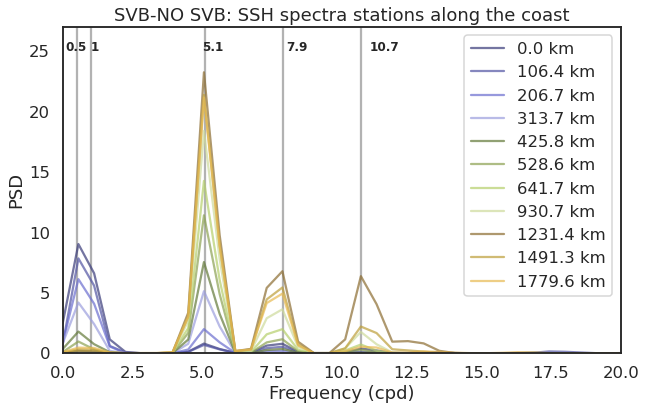

In [48]:
sns.set_style('white')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax) = plt.subplots(1,1,figsize=(10,6))

# Useful freq to period indicators
ax.axvline(0.5, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(1, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(5.1, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(7.9, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(10.7, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period

# ax.axvline(1e4/(8*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
# ax.axvline(1e4/(6*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
# ax.axvline(1e4/(3*3600), color='k', alpha=0.3, linestyle='-') # 1.2 hr 
# ax.axvline(1e4/(2.4*3600), color='k', alpha=0.3, linestyle='-') # 0.5 hr 
# ax.axvline(1e4/(240*3600), color='k', alpha=0.3, linestyle='-') # 24 hr 
ax.text(0.1,25,'0.5', fontweight='bold',fontsize=12)
ax.text(1,25,'1', fontweight='bold',fontsize=12)
ax.text(5,25,'5.1', fontweight='bold',fontsize=12)
ax.text(8,25,'7.9', fontweight='bold',fontsize=12)
ax.text(11,25,'10.7', fontweight='bold',fontsize=12)
# ax.text(1e4/((6-0.2)*3600),3E6,'6 hr', fontweight='bold',fontsize=12)
# ax.text(1e4/((3-0.05)*3600),3E6,'3 hr', fontweight='bold',fontsize=12) 
# ax.text(1e4/((2.4-0.01)*3600),3E6,'2.4 hr', fontweight='bold',fontsize=12)

# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[:,kk]-ssh_NOB[:,kk])*100, samp_freq, detrend='constant')
    ax.plot(freq_per*(86400), Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax.legend()
ax.set_ylim(0,27)
ax.set_xlim(0,20)
ax.set_ylabel('PSD')
ax.set_xlabel('Frequency (cpd)')
ax.set_title('SVB-NO SVB: SSH spectra stations along the coast')

Text(0.5, 1.0, 'NO SVB run')

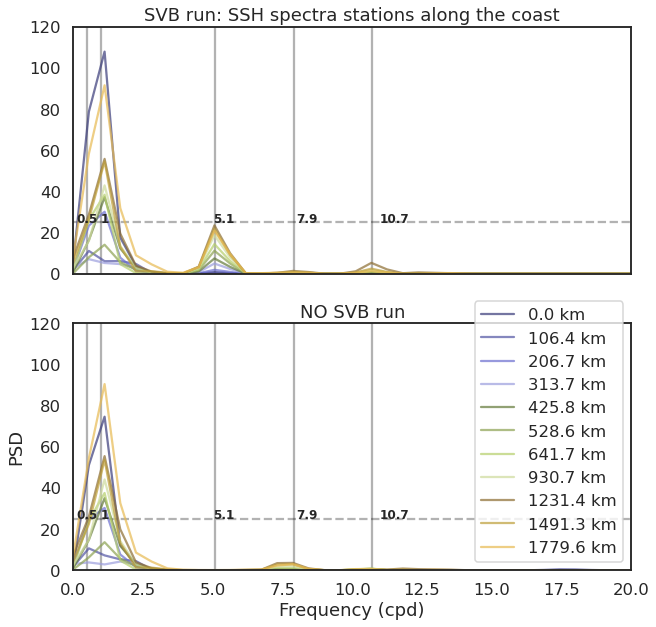

In [49]:
sns.set_style('white')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10), sharex=True, sharey=True)

# Useful freq to period indicators

for ax in [ax1,ax2]:
    ax.axvline(0.5, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(1, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(5.1, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(7.9, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(10.7, color='k', alpha=0.3, linestyle='-') 

    ax.axhline(25, color='k', alpha=0.3, linestyle='--') # y limit svb-nosvb spectra

    ax.text(0.1,25,'0.5', fontweight='bold',fontsize=12)
    ax.text(1,25,'1', fontweight='bold',fontsize=12)
    ax.text(5,25,'5.1', fontweight='bold',fontsize=12)
    ax.text(8,25,'7.9', fontweight='bold',fontsize=12)
    ax.text(11,25,'10.7', fontweight='bold',fontsize=12)

    
# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[:,kk])*100, samp_freq, detrend='constant')
    ax1.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])
    
# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh_NOB[:,kk])*100, samp_freq, detrend='constant')
    ax2.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,120)
ax2.set_ylabel('PSD')
ax2.set_xlabel('Frequency (cpd)')
ax1.set_title('SVB run: SSH spectra stations along the coast')
ax2.set_title('NO SVB run')

Text(0.5, 1.0, 'SVB-NO SVB: SSH spectra stations along the coast 1st day')

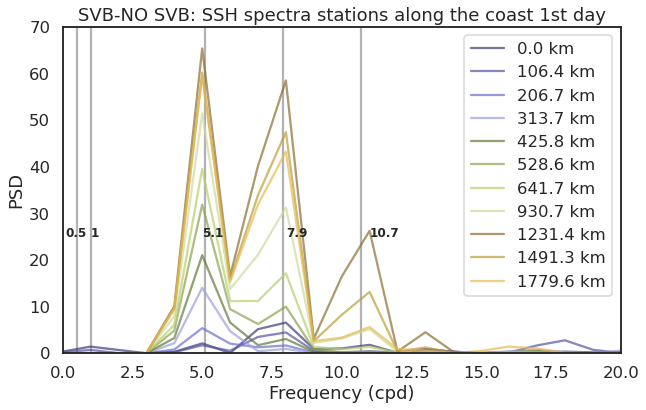

In [53]:
sns.set_style('white')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax) = plt.subplots(1,1,figsize=(10,6))

# Useful freq to period indicators
ax.axvline(0.5, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(1, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(5.1, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(7.9, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(10.7, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period

ax.text(0.1,25,'0.5', fontweight='bold',fontsize=12)
ax.text(1,25,'1', fontweight='bold',fontsize=12)
ax.text(5,25,'5.1', fontweight='bold',fontsize=12)
ax.text(8,25,'7.9', fontweight='bold',fontsize=12)
ax.text(11,25,'10.7', fontweight='bold',fontsize=12)

# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[:144,kk]-ssh_NOB[:144,kk])*100, samp_freq, detrend='constant')
    ax.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax.legend()
ax.set_ylim(0,70)
ax.set_xlim(0,20)
ax.set_ylabel('PSD')
ax.set_xlabel('Frequency (cpd)')
ax.set_title('SVB-NO SVB: SSH spectra stations along the coast 1st day')

Text(0.5, 1.0, 'NO SVB run')

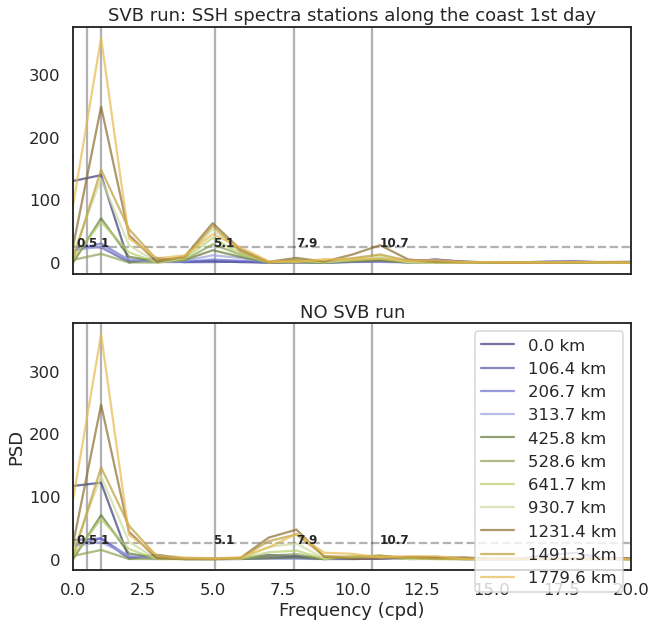

In [54]:
sns.set_style('white')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10), sharex=True, sharey=True)

# Useful freq to period indicators

for ax in [ax1,ax2]:
    ax.axvline(0.5, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(1, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(5.1, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(7.9, color='k', alpha=0.3, linestyle='-') 
    ax.axvline(10.7, color='k', alpha=0.3, linestyle='-') 

    ax.axhline(25, color='k', alpha=0.3, linestyle='--') # y limit svb-nosvb spectra

    ax.text(0.1,25,'0.5', fontweight='bold',fontsize=12)
    ax.text(1,25,'1', fontweight='bold',fontsize=12)
    ax.text(5,25,'5.1', fontweight='bold',fontsize=12)
    ax.text(8,25,'7.9', fontweight='bold',fontsize=12)
    ax.text(11,25,'10.7', fontweight='bold',fontsize=12)

    
# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[:144,kk])*100, samp_freq, detrend='constant')
    ax1.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])
    
# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh_NOB[:144,kk])*100, samp_freq, detrend='constant')
    ax2.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax2.legend()
ax2.set_xlim(0,20)
#ax2.set_ylim(0,240)
ax2.set_ylabel('PSD')
ax2.set_xlabel('Frequency (cpd)')
ax1.set_title('SVB run: SSH spectra stations along the coast 1st day')
ax2.set_title('NO SVB run')

Text(0.5, 1.0, 'SVB-NO SVB: SSH spectra stations along the coast after day 1')

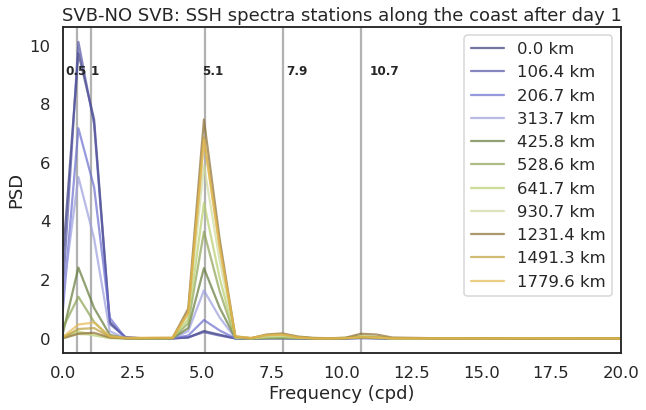

In [56]:
sns.set_style('white')
sns.set_context('talk')

samp_freq = 1/600 # 10 min data

fig,(ax) = plt.subplots(1,1,figsize=(10,6))

# Useful freq to period indicators
ax.axvline(0.5, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(1, color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(5.1, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(7.9, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(10.7, color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period

ax.text(0.1,9,'0.5', fontweight='bold',fontsize=12)
ax.text(1,9,'1', fontweight='bold',fontsize=12)
ax.text(5,9,'5.1', fontweight='bold',fontsize=12)
ax.text(8,9,'7.9', fontweight='bold',fontsize=12)
ax.text(11,9,'10.7', fontweight='bold',fontsize=12)

# cells along coast(ish)
for kk in [0,50,100,150,200,250,300,350,400,450,500]:
    freq_per, Pxx_den_per = signal.welch((ssh[144:,kk]-ssh_NOB[144:,kk])*100, samp_freq, detrend='constant')
    ax.plot(freq_per*86400, Pxx_den_per,'-', alpha=0.7, label='%1.1f km' %dist_cummul[kk])

ax.legend()
ax.set_xlim(0,20)
ax.set_ylabel('PSD')
ax.set_xlabel('Frequency (cpd)')
ax.set_title('SVB-NO SVB: SSH spectra stations along the coast after day 1')